# College Retention Predictions

by: Mathias Boissevain 2022-04-27

## Project Goal:

This repo is a compilation of work done to explore data from a large college in the western United States to identify drivers of retention and develop efficient classification models for predicting year over year retention.

## Project Description

College continues to be a large expense for adults in the United States. Ensuring students have every opportunity to finish their education should be of utmost importance to every University. In this project I will explore possible drivers that can help Universities identify which students are at risk of not being retained year over year. Student data will be explored and classification models will be assessed to identify which students the University should focus resources on to ensure they are equipped with what they need to finish their degrees and become thriving professionals.

Special Note: Project can not be reproduced as csv file is not included for reasons of anonymity.

## Summary of Findings

- Through exploration and modeling whether a student was enrolled in the semester between the retention calculation and the base semester showed the most drastic retention difference. Freshman students showed a much lower retention then the other classes. Lastely term_gpa was much lower in students that were not retained.

- Each individual row is considered an individual observation of retention year over a year based on variables provided. Individual students show up in dataset multiple times. So this is not a measure of whether an individual student is retained over time but a measure of individual instances of year over year retention. With more data provided and further exploration and analysis, more could be done to understand drivers of individual student retention.

## Data Dictionary

|Column Name|Column Description|
|:-:|:--|
|id|Proxy student ID|
|retained|Y/N flag for whether a student was retained fall-fall or spring-spring
|enrolled_between|Y/N flag for whether a student was enrolled in the fall or spring semester in between the retained span|
|race_ethn|Race/ ethnicity|
|sex|Sex|
|time_status|Full or part time status based on credits attempted|
|fgen|First generation student status|
|student_year|Student Classification (freshmen, sophomore,etc)|
|pell_ever|Whether or a not a student has ever been Pell grant eligible|
|efc|Expected Family Contribution (null where no FAFSA received)|
|hs_gpa|High School GPA where available|
|term_gpa|Term grade point average in base semester of retention calculation|	
|enroll_type|A student's original student type when beginning at the university|
|cip|2 digit classification of instructional program|
|age_at_start_term|Age at the start of the term for the base semester of the retention calculation|
|act|ACT score bucket where available|
|academic_standing|Academic standing bucket (here grouped into good or issue bins)	|
|fa_recd|Whether or a not a student received financial aid in the base semester of retention calculation|
|depend_status|Students' financial dependency status|
|withdrawal|Whether a student received a W grade in the base semester of retention calculation|
|yr_since_start|Groupings of years between when a student began and the start date of the base semester of the retention calculation|
|reg_before_start|Number of days between when a student registered for the base semester of the retention calculation and that semester's start date|
|base semester|The semester from which the data came. First fall/spring in fall to fall or spring to spring|

# Wrangle University Data

Pandas was used to read in the data from a csv file. The function to do so can be found in the wrangle.py file in the project github repository found in the following link:

https://github.com/mwboiss/retention-project

In [23]:
# Import for Data manipulation
import pandas as pd
# Import for Data acquisition and prep
import wrangle
# Using the acquire and prep function found in the wrangle.py file we assign the dataframe
df = wrangle.acquire_student_data()
students , sparce_dummies = wrangle.prep_student_data(df)

# Import warnings to remove popup warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display

The data was cleaned in the following steps:

1. Column names were reformated for usability
2. cip code descriptions were acquired from a csv and merged to match cip codes in the student dataframe
3. age_at_start_term column was cleaned of spaces
4. categorical data that had a boolean shape were encoded to boolean values
5. the rest of the categorical data was one hot encoded and added to the dataframe
6. efc, hs_gpa were dropped due to missing data (Area of further analysis)

In [2]:
# The data is split with a fuction that takes in our original dataframe and the target variable and returns the following
train, validate, test = wrangle.split_data(students,'retained')

Our data is split into 3 samples:
- The train sample represents 56 % of the data and is used to train the model
- The validate sample represents 24 % of the data and is used to test for overfitting
- The test sample reresents 20 % of the data and is used to test our top model
- All splits were done with a seed of 1729 and retained was used as the stratify variable to ensure a balanced ratio in samples

## Data Context

- Original DataFrame is 448,176 rows with 22 columns
- After acquistion and preperation of data we are left with 448,086 rows with 87 columns
- With an average overall retention rate of 68% 
- Each row represents an individual instance of year over year retention. Individual students are reperesented once for every semester they attended

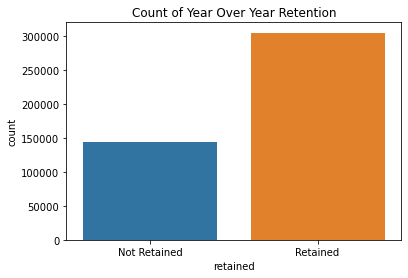

In [3]:
# Import seaborn and matplotlib for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
# Plot data count by retention
ax = sns.countplot(x='retained',data=students)
plt.title('Count of Year Over Year Retention')
ax.set_xticklabels(['Not Retained','Retained'])
plt.show()

# Exploratory Data Analysis:

## Questions Answered:

Question 1: Does the students class status (Freshman, Sophmore,etc..) vs the years since a student started affect retention?

Question 2: Does whether a student was enrolled between the retention semester affect retention?

Question 3: Does a students term gpa affect retention?

Question 4: Does whether a student withdrew from a course affect retention?

Question 5: Does a students full time or part time status affect retention?

### Question 1:  Does the students class status (Freshman, Sophmore,etc..) vs the years since a student started affect retention?

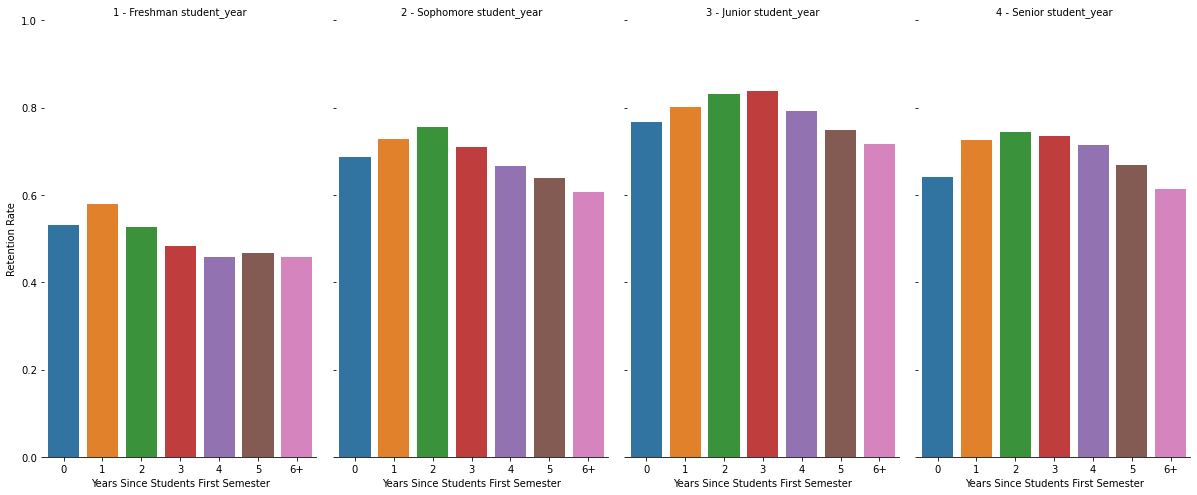

In [31]:
# A dataframe is formed to plot the needed data
class_and_yr = train[['student_year','yrs_since_start','retained']].groupby(['student_year','yrs_since_start']).mean().reset_index()
# Variables names are changed for plotting
class_and_yr['student_year'] = class_and_yr.student_year.str.replace('FR','1 - Freshman').str.replace('SO','2 - Sophomore').str.replace('JU','3 - Junior').str.replace('SE','4 - Senior')
# Values are sorted for plotting
class_and_yr = class_and_yr.sort_values(by='student_year')
# Data is put into a catplot
ax = sns.catplot(x="yrs_since_start", y="retained", col="student_year",
                data=class_and_yr, height = 7,
                kind="bar", aspect=.6)
# Tiles and axis labels are assigned
(ax.set_axis_labels("Years Since Students First Semester", "Retention Rate")
  .set_xticklabels(["0", "1", "2", "3", "4", "5", "6+"])
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 1))
  .despine(left=True))  
plt.show()

#### Question 1 Summary: Freshman by far have the lowest retention across the yrs. Juniors and Seniors have the highest. Further exploration could be done with enrollment type to see how first time students compare to transfer students as well, populations could be seperated by full time and part time status. 

### Question 2: Does whether or not a student was enrolled between the retention semester affect retention?

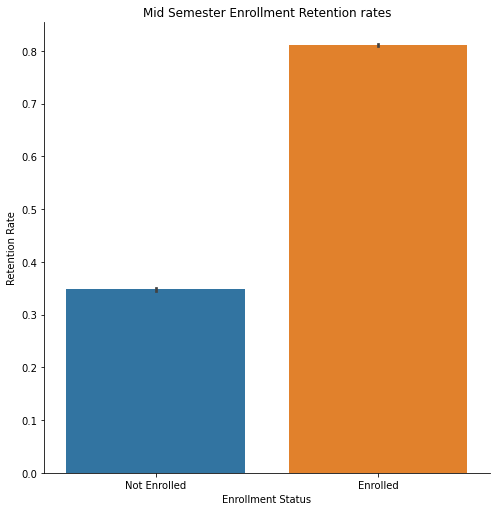

In [38]:
# A catplot with kind bar is used to show retention rates for mid semester enrollment status
ax = sns.catplot(x='enrolled_between',y='retained',data=train, kind='bar',height=7)
# Set axis labels
(ax.set_axis_labels("Enrollment Status", "Retention Rate")
  .set_xticklabels(["Not Enrolled", "Enrolled"]))
# Set title
plt.title("Mid Semester Enrollment Retention rates")
plt.show()

#### Chi Squared Hypothesis Test

- $H_o$: Mid semester enrollment is independent of whether or not someone is retained.
- $H_α$: Mid semester enrollment is not independent of whether or not someone is retained.

In [6]:
# Import stats to run hypothesis test
import scipy.stats as stats
# Create contingnecy table
contingency_table = pd.crosstab(train.enrolled_between , train.retained)
# Run stats test
chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
# print result
print(f'P value: {p}')

P value: 0.0


- We reject the null hypothesis with a zero p-value. It is well below our significance level.

#### Question 2 Summary: If a student was not enrolled between the retention semester it seems to be the biggest indicator that they will not be retained. According to the Chi^2 test mid semester enrollment is not independent of retention.

### Question 3: Does a students term gpa affect retention?

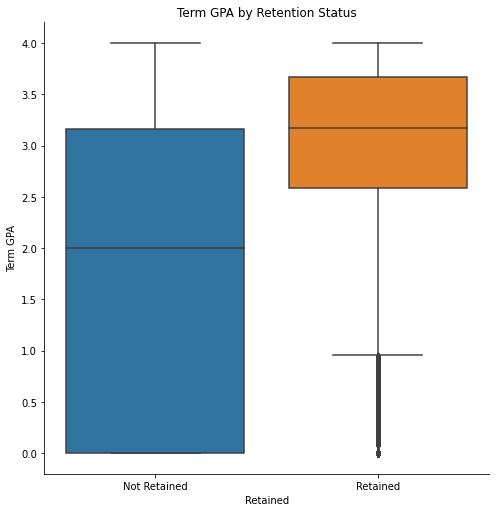

In [34]:
# Plot Term GPA box plots by retention rate
ax = sns.catplot(x='retained',y='term_gpa',data = train, kind ='box',height=7)
# Assign title
plt.title('Term GPA by Retention Status')
ax.set_axis_labels('Retained','Term GPA')
ax.set_xticklabels(['Not Retained','Retained'])
plt.show()

#### Question 3 Summary: Term gpa seems to be a decent predictor. Bottom 75 % of students in the not retained category had a term_gpa less than the bottom 50 % of those retained.

### Question 4: Does whether a student withdrew from a course affect retention?

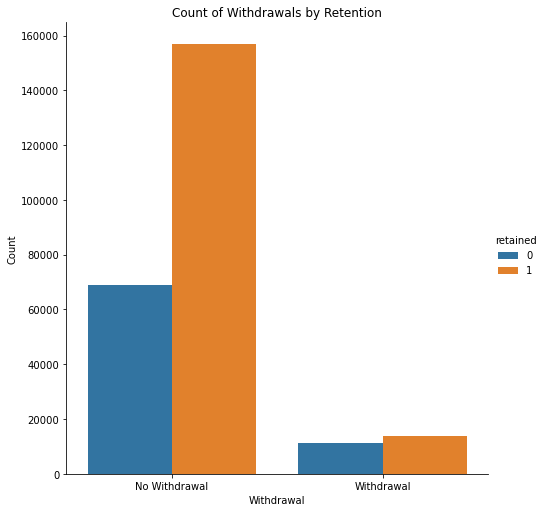

In [35]:
# Plot with catplot,kind = count
ax = sns.catplot(x='withdrawal',
              hue='retained',
              data=train,
              kind='count',
              height=7)
# Set title
plt.title('Count of Withdrawals by Retention')
# Set x labels
ax.set_axis_labels('Withdrawal','Count')
ax.set_xticklabels(["No Withdrawal", "Withdrawal"]) 
plt.show()

#### Chi Squared Hypothesis Test

- $H_o$: withdrawal is independent of whether or not someone is retained.
- $H_α$: withdrawal is not imdependent of whether or not someone is retained.

In [9]:
# Set contingency table
contingency_table = pd.crosstab(train.withdrawal, train.retained)
# Run Chi^2 test
chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
# Print results
print(f'p     = {p:.4f}')

p     = 0.0000


- We reject the null

#### Question 4 Summary: 70 percent of students did not have a withdrawal in the base semester of the retention calculation, out of those students the retention rate was higher than the average. The 30 percent of students with at least one withdrawal had a much lower retention rate of 55 percent.

### Question 5: Does a students full time or part time status affect retention?

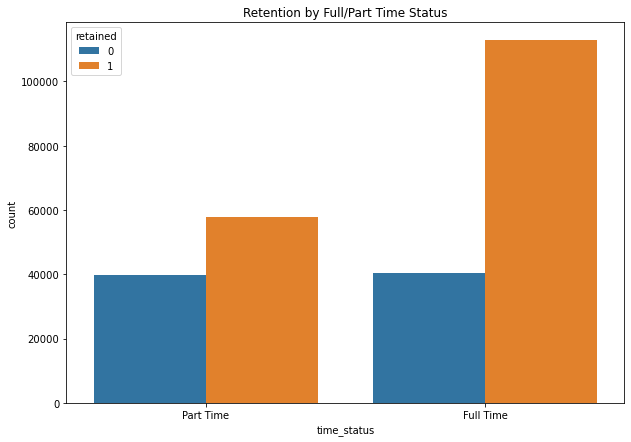

In [37]:
# Set figure size
plt.figure(figsize=(10,7))
# Plot data
ax = sns.countplot(x = 'time_status',data=train,hue='retained')
# Set labels
ax.set_xticklabels(['Part Time','Full Time'])
plt.title('Retention by Full/Part Time Status')
plt.show()


#### Chi Squared Hypothesis Test

- $H_o$: time_status is independent of whether or not someone is retained.
- $H_α$: time_status is not imdependent of whether or not someone is retained.

In [11]:
# Set contingency table
contingency_table = pd.crosstab(train.time_status, train.retained)
# Perform test
chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
# Print P-value
print(f'p     = {p:.4f}')

p     = 0.0000


- We reject the null.

#### Question 5 Summary: It does look as though full time students are more likely to be retained. The chi^2 test does show that there is a statistically significant relationship between time_status and retention.

### EDA Summary: Freshman status, whether a student was enrolled between the retention semesters, term_gpa, whether a student withdrew from a class, and part/full time status all showed to be potential indicators of retention status. Whether a student was enrolled between retention semesters showed the most drastic difference in retention status.

#### Questions and Conclusions

Question 1: Does the students class status (Freshman, Sophmore,etc..) vs the years since a student started affect retention?

Question 1 Summary: Freshman by far have the lowest retention across the yrs. Juniors and Seniors have the highest. Further exploration could be done with enrollment type to see how first time students compare to transfer students. As well populations can be seperated by full time and part time status. 

Question 2: Does whether or not a student was enrolled between the retention semester affect retention?

Question 2 Summary: If a student was not enrolled between the retention semester it seems to be the biggest indicator that they will not be retained. According to the Chi^2 test mid semester enrollment is not independent of retention.

Question 3: Does a students term gpa affect retention?

Question 3 Summary: Term gpa seems to be a decent predictor. Bottom 75 % of students in the not retained category had a term_gpa less than the bottom 50 % of those retained. Also note for later analysis hs_gpa does not change with a student over time but term_gpa does.

Qestion 4: Does whether a student withdrew from a course affect retention?

Question 4 Summary: 70 percent of students did not have a w_count in the base semester of the retention calculation, out of those students the retention rate was higher than the average. The 30 percent of students with at least one withdraw had a much lower retention rate of 55 percent.

Question 5: Does a students full time or part time status affect retention?

Question 5 Summary: It does look as though full time students are more likely to be retained. The chi^2 test does show that there is a statistically significant relationship between time_status and retention.

# Modeling

In [12]:
# Import function to split data for modeling as well as sklearn for model reporting
from wrangle import model_split
from sklearn.metrics import classification_report
from sklearn import metrics

In [13]:
model_train = train[train.columns[(train.dtypes != 'object') & (train.columns != 'id')]]
model_validate = validate[validate.columns[(validate.dtypes != 'object') & (validate.columns != 'id')]]
model_test = train[test.columns[(test.dtypes != 'object') & (test.columns != 'id')]]

### Evaluation Metric

When evaluating the models I beleive its important to understand when our model predicts both retained and not retained (model accuracy). This is important when ensuring we are reaching out to the correct individauls when offering support.

### Baseline

In [14]:
# Setting a baseline of Retained or 1 as it is the most frequent

# We split the target from the data to model
X_train, y_train = model_split(model_train, 'retained')
# We use the DummyClassifier from sklearn to create a baseline accuracy.
from sklearn.dummy import DummyClassifier 

# Here we create and fit the model
dummy = DummyClassifier(strategy='most_frequent', random_state = 1729, constant = None)
dummy.fit(X_train, y_train)   

# Here we create our predictions
y_pred = dummy.predict(X_train)

# Check report for current baseline accuracy: 0.70
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     80251
           1       0.68      1.00      0.81    170676

    accuracy                           0.68    250927
   macro avg       0.34      0.50      0.40    250927
weighted avg       0.46      0.68      0.55    250927



## Train

Out of the models ran the top are presented below. The Decision Tree ran the best

In [15]:
# Import the sklearn Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Split the data
x_train_dt, y_train_dt = wrangle.model_split(model_train, 'retained')

# Create the model
dtc = DecisionTreeClassifier(max_depth=4, random_state=1729)

# Fit the model to training set
dtc = dtc.fit(x_train_dt, y_train_dt)

# Predict on trianing set
y_pred_dt = dtc.predict(x_train_dt)

# Print the report
print(classification_report(y_train_dt, y_pred_dt))

              precision    recall  f1-score   support

           0       0.81      0.52      0.63     80251
           1       0.81      0.94      0.87    170676

    accuracy                           0.81    250927
   macro avg       0.81      0.73      0.75    250927
weighted avg       0.81      0.81      0.79    250927



In [16]:
# Import the sklearn Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Split the data
x_train_rf, y_train_rf = wrangle.model_split(model_train, 'retained')

# Create the model
rf = RandomForestClassifier(min_samples_leaf=3,
                            max_depth=3, 
                            random_state=1729)

# Fit the model
rf.fit(x_train_rf, y_train_rf)

# Predict on train
y_pred_rf = rf.predict(x_train_rf)

# Print Report
print(classification_report(y_train_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.28      0.42     80251
           1       0.74      0.98      0.85    170676

    accuracy                           0.76    250927
   macro avg       0.81      0.63      0.63    250927
weighted avg       0.79      0.76      0.71    250927



In [17]:
# Import sklearn logistic Regression classifier
from sklearn.linear_model import LogisticRegression

# Split the data
x_train_lr, y_train_lr = wrangle.model_split(model_train, 'retained')

# Create the model
logit = LogisticRegression(C=10, random_state=1729)

# Fit the model to training set
logit.fit(x_train_lr, y_train_lr)

# Predict on training set
y_pred_lr = logit.predict(x_train_lr)

# Print the report
print(classification_report(y_train_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.56      0.65     80251
           1       0.82      0.92      0.87    170676

    accuracy                           0.81    250927
   macro avg       0.79      0.74      0.76    250927
weighted avg       0.80      0.81      0.80    250927



### Validate

The models were tested with the validate set to ensure no overfitting. The Decision Tree model continued to perform the best.

In [18]:
# Split Validate set
x_validate_dt, y_validate_dt = wrangle.model_split(model_validate, 'retained')

# Predict on validate set
y_pred_val_dt = dtc.predict(x_validate_dt)

# Print Classificaiton report
print(classification_report(y_validate_dt, y_pred_val_dt))

              precision    recall  f1-score   support

           0       0.81      0.52      0.63     34394
           1       0.81      0.94      0.87     73147

    accuracy                           0.81    107541
   macro avg       0.81      0.73      0.75    107541
weighted avg       0.81      0.81      0.79    107541



In [19]:
# Split Validate Set
x_validate_rf, y_validate_rf = wrangle.model_split(model_validate, 'retained')

# Predict on validate set
y_pred_val_rf = rf.predict(x_validate_rf)

# Print Report
print(classification_report(y_validate_rf, y_pred_val_rf))

              precision    recall  f1-score   support

           0       0.88      0.28      0.42     34394
           1       0.74      0.98      0.85     73147

    accuracy                           0.76    107541
   macro avg       0.81      0.63      0.63    107541
weighted avg       0.79      0.76      0.71    107541



In [20]:
# Split Validate Set
x_validate_lr, y_validate_lr = wrangle.model_split(model_validate, 'retained')

# Predict on validate set
y_pred_val_lr = logit.predict(x_validate_lr)

# Print Report
print(classification_report(y_validate_lr, y_pred_val_lr))

              precision    recall  f1-score   support

           0       0.77      0.56      0.65     34394
           1       0.82      0.92      0.87     73147

    accuracy                           0.81    107541
   macro avg       0.79      0.74      0.76    107541
weighted avg       0.80      0.81      0.80    107541



### Test

The top performing model was passed to the test stage and continued to perform well. 

In [21]:
# Split test set
x_test_dt, y_test_dt, = wrangle.model_split(model_test, 'retained')

# Predict on test set
y_pred_test_dt = dtc.predict(x_test_dt)

# Print Report
print(classification_report(y_test_dt, y_pred_test_dt))

              precision    recall  f1-score   support

           0       0.81      0.52      0.63     80251
           1       0.81      0.94      0.87    170676

    accuracy                           0.81    250927
   macro avg       0.81      0.73      0.75    250927
weighted avg       0.81      0.81      0.79    250927



## View of the Decision Tree

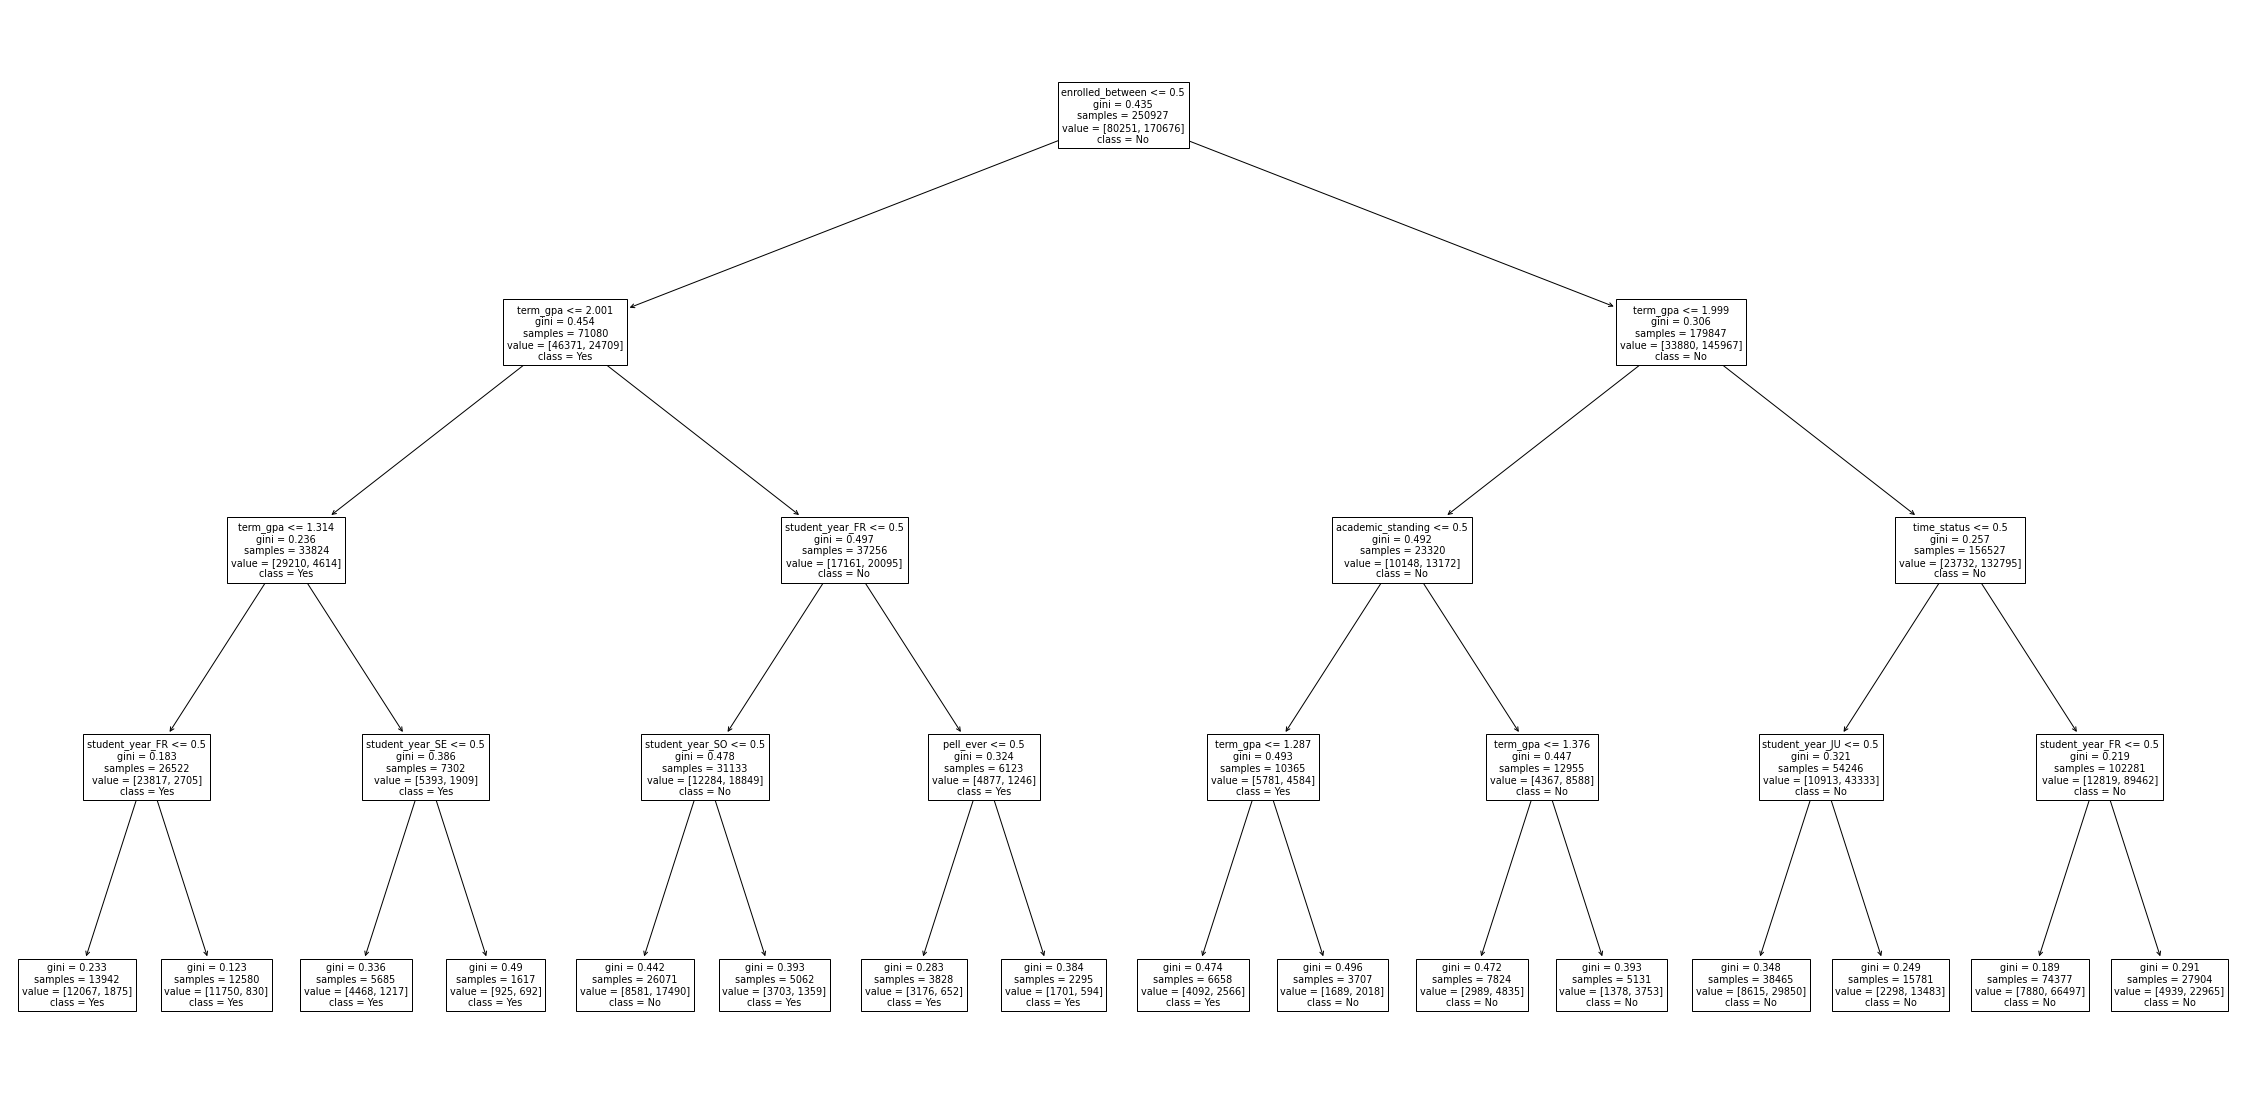

In [22]:
# Import plot_tree from sklearn to show decision tree
from sklearn.tree import plot_tree
# Set figure size
plt.figure(figsize=(40,20))
# Plot tree
plot_tree(dtc, feature_names = x_train_dt.columns, class_names=['Yes','No'])
plt.show()

Model Summary: The Decision tree model outperformed all other models with 13 % above the baseline through train, validate and test. As the Tree above shows enrolled_between, term_gpa and student_year were all important drivers of retention.

# Conclusion

### Summary: 

Through exploration and modeling whether a student was enrolled in the semester between the retention calculation and the base semester showed the most drastic retention difference. Freshman students showed a much lower retention then the other classes. Lastely term_gpa was much lower in students that were not retained.

### Recommendations

A good area of focus for out reach would be Freshman students especially those who end up with a low GPA their first term. 

### Next Steps

Given more time, further analysis on feature engineering, clustering, and ensemble modeling should be explored. Null values that were dropped should be explored to see if more data can be retained. Given a bit more data a lot more analysis could be done to explore retention across individual students. If there was a way to designate the order of semesters and how they are seperated (fall/spring) for each student ID more analysis can be done. Lastly exploring how students could be seperated into different sample groups (Freshman, full time status, transfer vs first time students) and explored seperately may help in the identificaiton in those who are at risk of not being retained. 

Further exploration potential questions with more data:

- Did students just drop out, did they transfer or did they graduate?
- Were they fall to fall or spring to spring and did that affect how early they registered? 140 for Fall, 85 for Spring
- Further exploration of senior retention? Did they graduate? What happened?